In [1]:
import torch
from transformers import pipeline
import fiftyone as fo
import boto3
import os

import numpy as np
from tqdm import tqdm 
from PIL import Image
import pandas as pd

%load_ext autoreload
%autoreload 2


# Load the fiftyone dataset and its images

In [2]:
ds = fo.Dataset.from_dir('data/metadata', fo.types.FiftyOneDataset)
for sample in tqdm(ds): 
    file_id = sample.filepath.split('/')[-1]
    if not os.path.exists(f'data/samples/{file_id}'):
        boto3.client('s3').download_file('reversefashion-images', f"s/{file_id}", f'../data/samples/{file_id}')

Importing samples...
 100% |███████████████| 2223/2223 [51.0ms elapsed, 0s remaining, 43.6K samples/s]   
Migrating dataset '2025.11.07.15.42.37.073347' to v1.10.0


100%|██████████| 600/600 [00:00<00:00, 2265.18it/s]


In [3]:
from utils import load_Siglip2, apply_model_on_ds, load_Siglip, Load_Dino3
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# ds_temp = ds.match(fo.ViewField("Category three").contains(['Shirts', 'Tops & Blouses']))
# candidate_labels = ['a shirt with breast pockets', 'a shirt', 'a blouse', 'a top']


ds_temp = ds.match(fo.ViewField("Category three").contains(['Jeans']))
candidate_labels = ['a male jeans', 'a female jeans', 'a curvy cut jeans' ,'a jeans with short zipper']

category = "Category two"

# Test Siglip2
pipeline = load_Siglip2("google/siglip2-large-patch16-256")
df_Siglip2 = apply_model_on_ds(
    ds_temp,
    pipeline_instance=pipeline,
    target_field=category,
    candidate_labels=candidate_labels,
)
del pipeline
torch.cuda.empty_cache()
df_Siglip2["model_type"] = "siglip2"
df_Siglip2["checkpoint"] = "google/siglip2-large-patch16-256"


# Test Fashionsiglip

model, tokenizer, preprocessor = load_Siglip()

df_Siglip = apply_model_on_ds(
    ds_temp,
    model=model,
    tokenizer=tokenizer,
    preprocessor=preprocessor,
    target_field=category,
    candidate_labels=candidate_labels
)
del model, tokenizer, preprocessor
torch.cuda.empty_cache()

df_Siglip["model_type"] = "siglip"
df_Siglip["checkpoint"] = "marquo"


# Test Dinov3
model, tokenizer, preprocessor = Load_Dino3(256)
df_Dino3 = apply_model_on_ds(
    ds_temp,
    model=model,
    tokenizer=tokenizer.tokenize,
    preprocessor=preprocessor,
    target_field=category,
    candidate_labels=candidate_labels
)
del model, tokenizer, preprocessor
torch.cuda.empty_cache() 
df_Dino3["model_type"] = "Dinov3"
df_Dino3["checkpoint"] = "Dinov3txt"


df = pd.concat([df_Siglip, df_Siglip2, df_Dino3])


print('/n/n/n')
for model in df["model_type"].unique():
    print(model)
    display(df[df["model_type"] == model].groupby(['label', 'pred']).size().unstack())

Device set to use cuda
100%|██████████| 134/134 [00:08<00:00, 14.99it/s]


/n/n/n
siglip


pred    a curvy cut jeans  a female jeans  a male jeans
label                                                  
Mens                  1.0             3.0          71.0
Unisex                NaN             1.0           4.0
Womens                8.0            31.0          15.0

siglip2


pred    a curvy cut jeans  a female jeans  a male jeans
label                                                  
Mens                 27.0             NaN          48.0
Unisex                1.0             1.0           3.0
Womens               35.0            11.0           8.0

Dinov3


pred    a curvy cut jeans  a female jeans  a male jeans
label                                                  
Mens                 21.0            51.0           3.0
Unisex                1.0             4.0           NaN
Womens                9.0            44.0           1.0

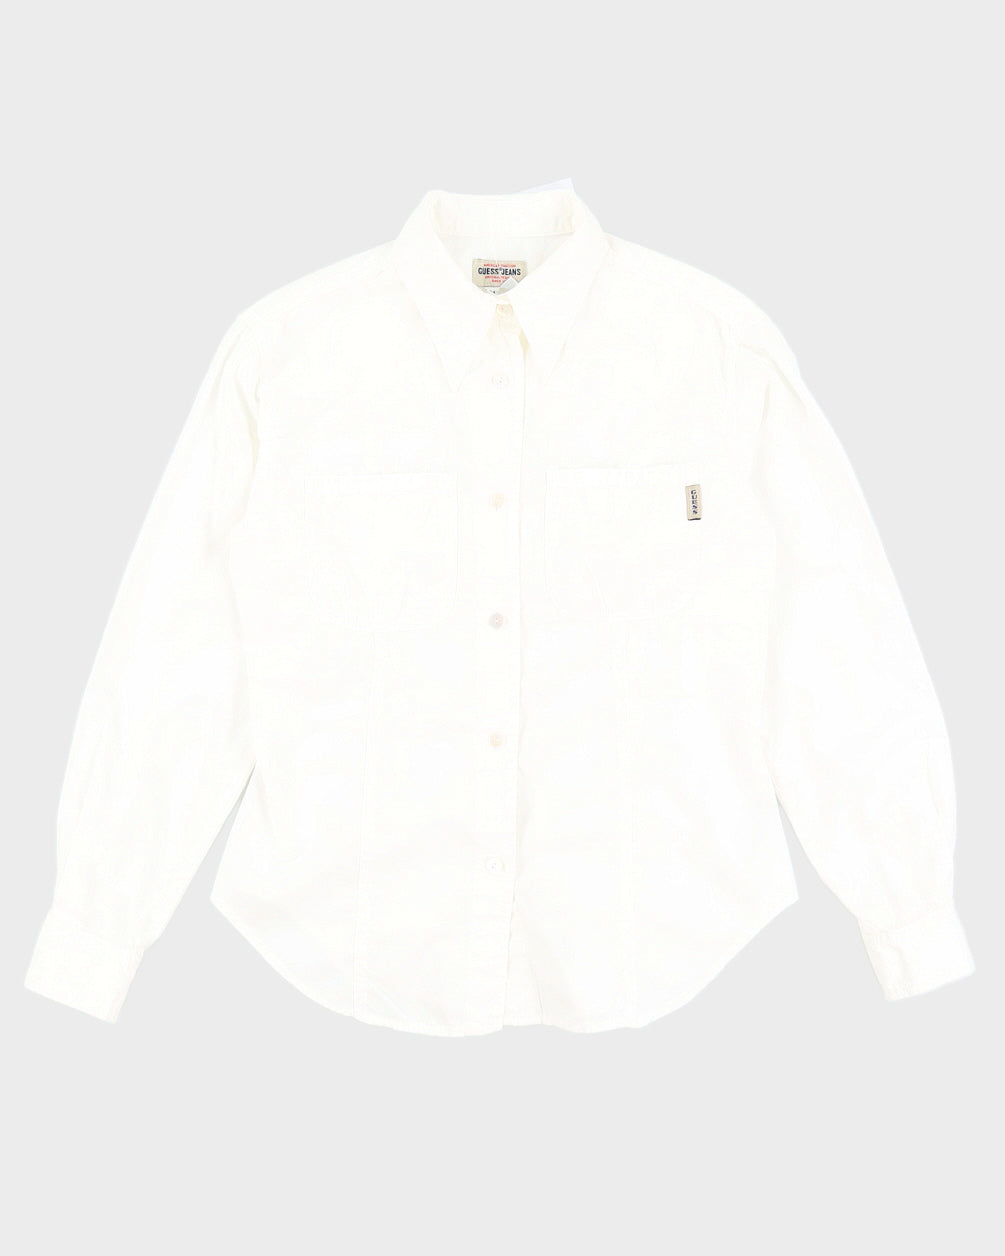

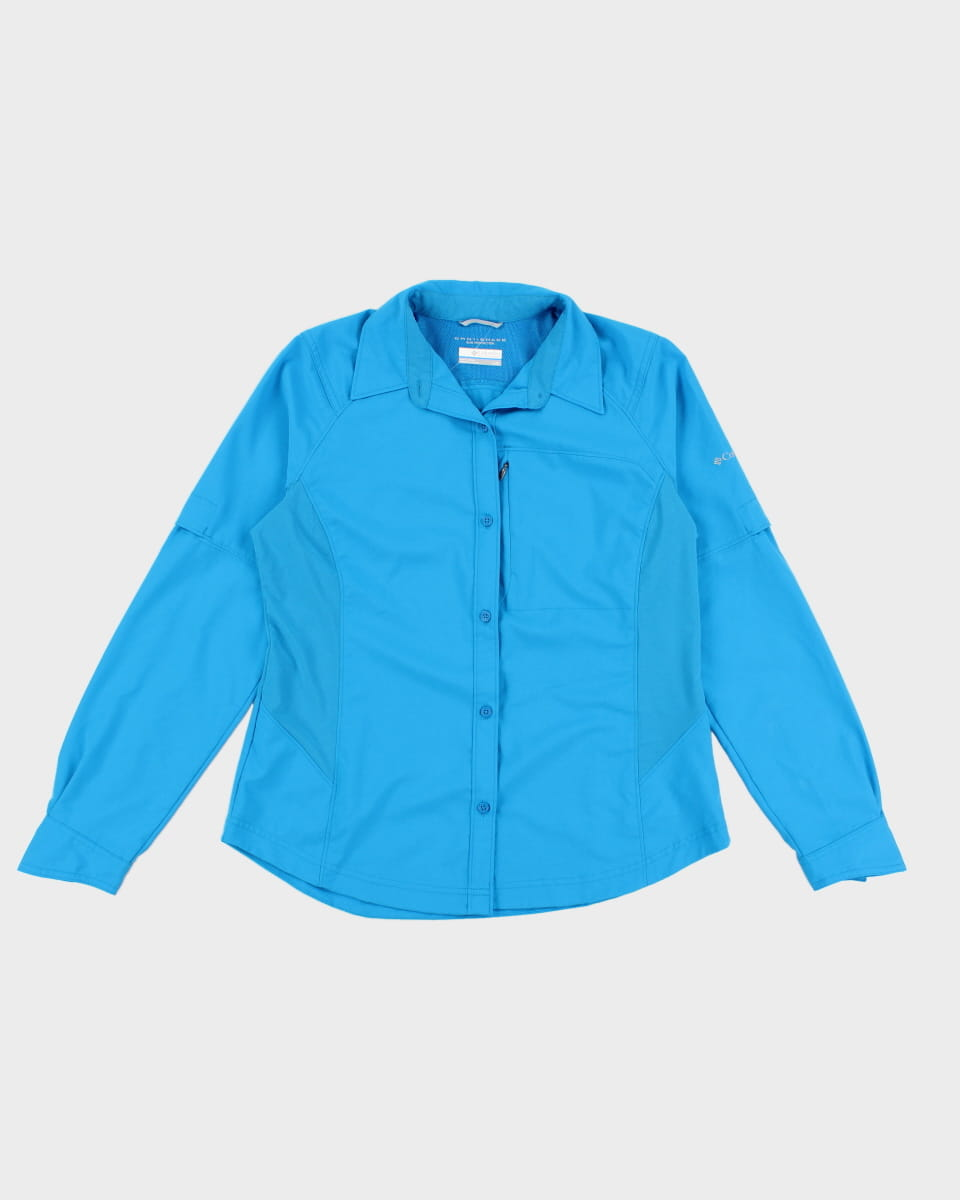

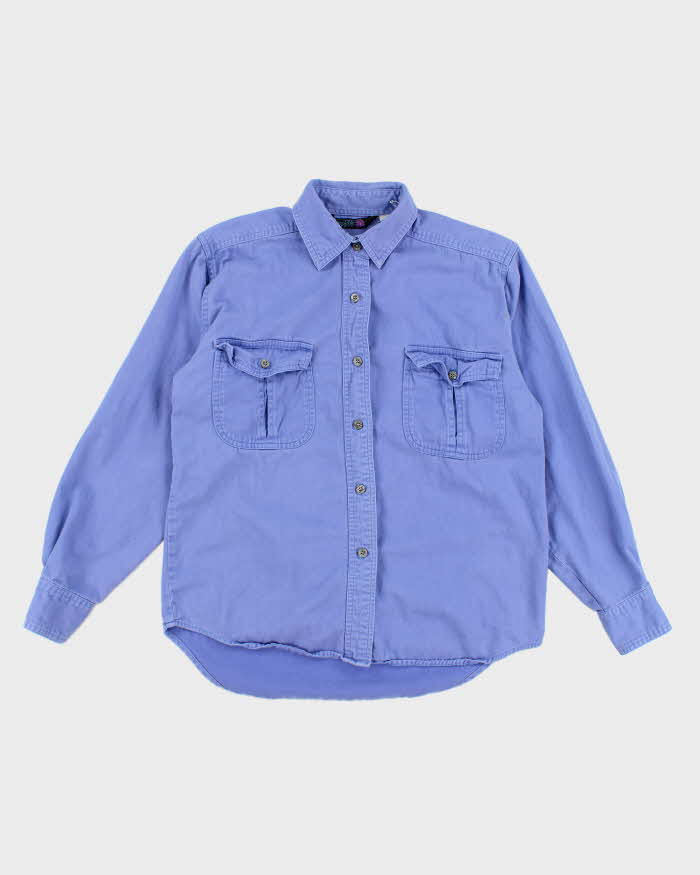

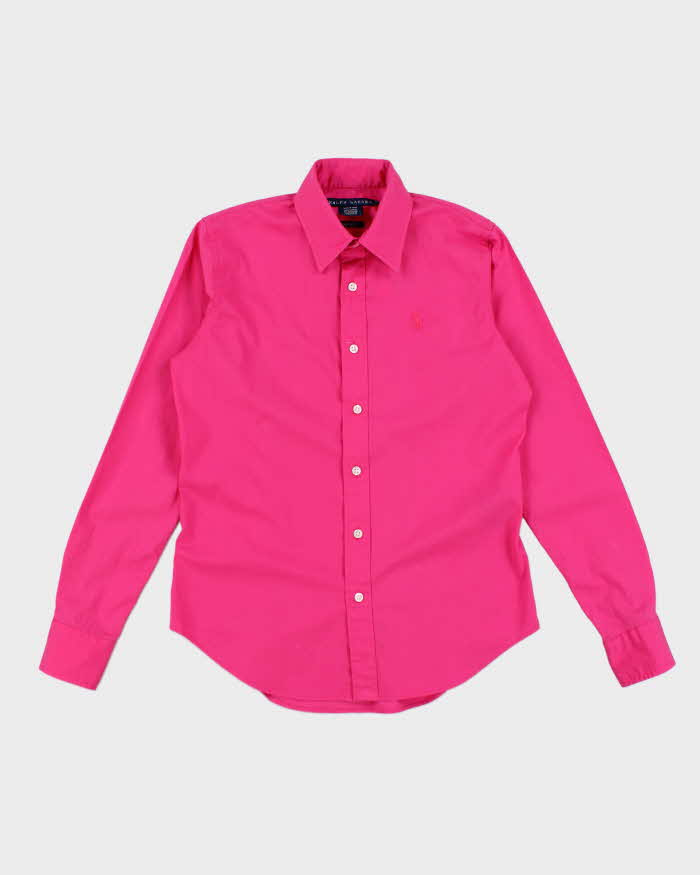

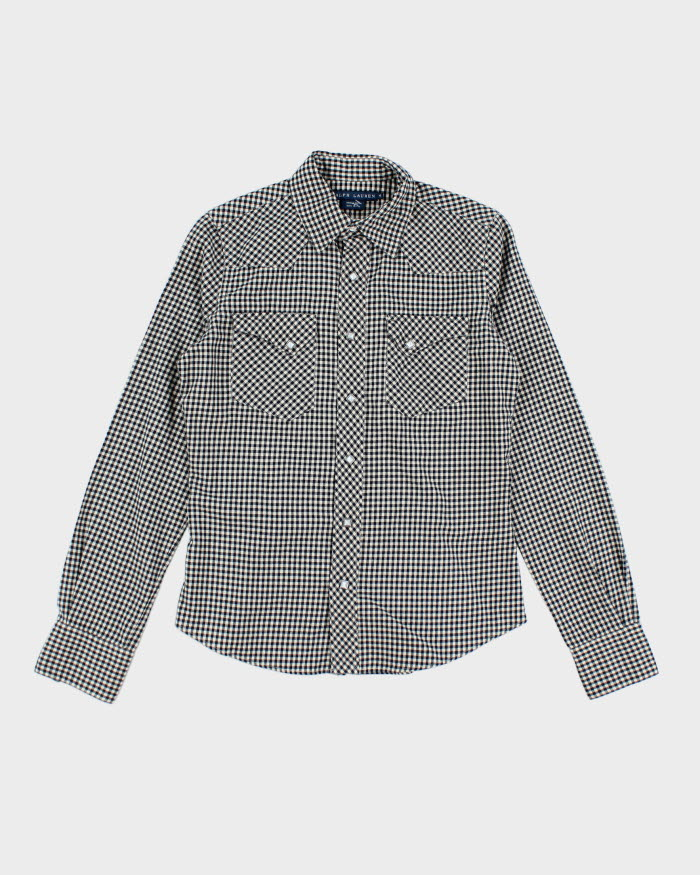

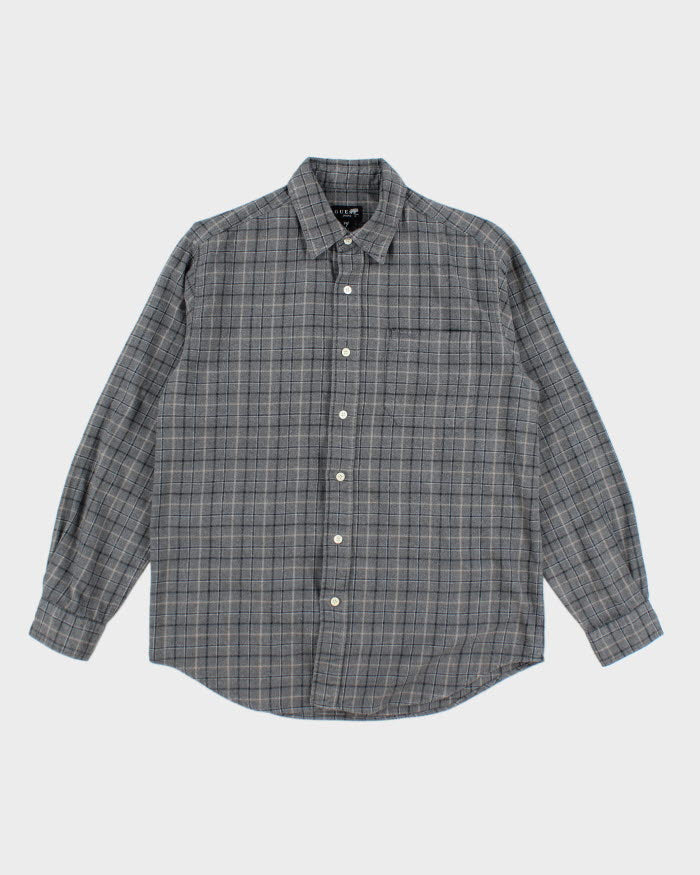

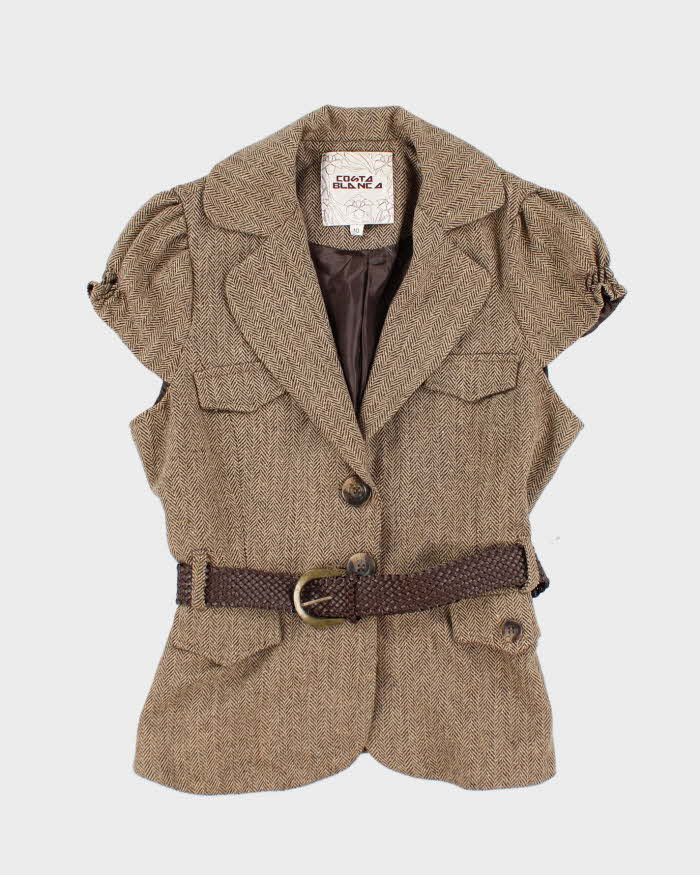

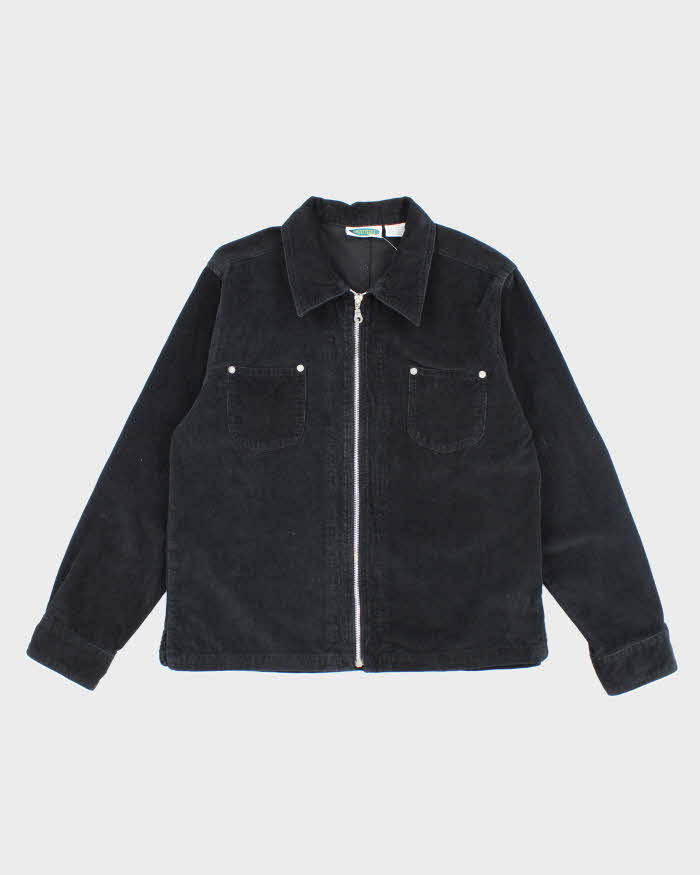

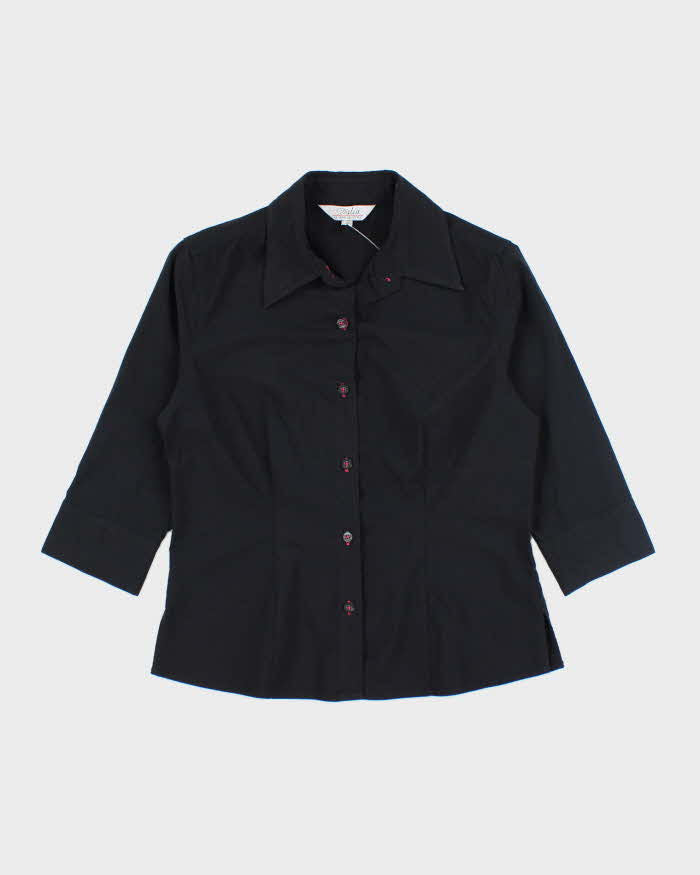

In [30]:
temp = df[df["model_type"] == 'siglip']
temp = temp[temp["label"] == 'Womens']
temp = temp[temp["pred"] == 'a shirt with breast pockets']

for file_id in temp['file_id'].values:
    img = Image.open(f"data/samples/{file_id}")
    display(img)

In [16]:
temp['file_id'].values

array(['8112419897598_1.jpg', '8190138745086_1.jpg',
       '8303234023678_1.jpg', '8338024071422_1.jpg',
       '8471339565310_1.jpg', '8554141843710_1.jpg',
       '8584590917886_1.jpg', '8587781243134_1.jpg',
       '14608558195071_1.jpg', '14610519490943_1.jpg',
       '14617540428159_1.jpg', '14619258323327_1.jpg',
       '14897515463039_1.jpg', '14914227175807_1.jpg',
       '14915261497727_1.jpg', '14915261890943_1.jpg'], dtype=object)

In [12]:
temp["label"]

Series([], Name: label, dtype: object)

In [ ]:

import matplotlib.pyplot as plt

plt.matshow(df[['label', 'pred']].corr())
plt.show()

ValueError: could not convert string to float: 'Mens'

In [ ]:
# Test Siglip2
pipeline = load_Siglip2("google/siglip2-large-patch16-256")
df_Siglip2 = apply_model_on_ds(ds, pipeline_instance = pipeline)
del pipeline
torch.cuda.empty_cache()
df_Siglip2['model_type'] = 'siglip2'
df_Siglip2['checkpoint'] = 'google/siglip2-large-patch16-256'


# Test Fashionsiglip

model, tokenizer, preprocessor = load_Siglip()

df_Siglip = apply_model_on_ds(ds, model=model, tokenizer=tokenizer, preprocessor=preprocessor)
del model, tokenizer, preprocessor
torch.cuda.empty_cache()

df_Siglip['model_type'] = 'siglip'
df_Siglip['checkpoint'] = 'marquo'


# Test Dinov3
model, tokenizer, preprocessor  = Load_Dino3(256)
df_Dino3 = apply_model_on_ds(ds, model=model, tokenizer=tokenizer.tokenize, preprocessor=preprocessor)
del model, tokenizer, preprocessor
torch.cuda.empty_cache()
df_Dino3['model_type'] = 'Dinov3'
df_Dino3['checkpoint'] = 'Dinov3txt'


df = pd.concat([df_Siglip, df_Siglip2, df_Dino3])

df['pred_correct'] = df['label'].apply(lambda x: x.lower()) == df['pred']
df[['checkpoint', 'pred_correct']].groupby('checkpoint').mean()

100%|██████████| 600/600 [00:12<00:00, 46.29it/s]


pred_correct
checkpoint                                    
Dinov3txt                             0.746667
google/siglip2-large-patch16-256      0.781667
marquo                                0.750000